In [1]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions
import matplotlib

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("matplotlib", matplotlib.__version__)

gammapy: 0.19
numpy: 1.21.5
astropy 4.3.1
regions 0.5
matplotlib 3.5.1


In [2]:
%matplotlib inline
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')
from matplotlib.offsetbox import AnchoredText
from pathlib import Path
from regions import CircleSkyRegion

from astropy.time import Time

from gammapy.maps import Map, RegionGeom
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    MapDataset,
    FluxPointsDataset
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import LightCurveEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, PowerLawSpectralModel, ExpCutoffPowerLawSpectralModel, LogParabolaSpectralModel
from gammapy.visualization import plot_spectrum_datasets_off_regions
from gammapy.makers.utils import make_theta_squared_table
from gammapy.visualization import plot_theta_squared_table
import pickle

In [3]:
location_data = '/home/lavergne/Téléchargements/hess_dl3_dr1/' #path to DL3 folder
source_name = 'Crab' #e.g., Crab, GRB210807A
cut_type = 'loose' #e.g., loose, hard, ...
filename_output = '{name}_{cut}'.format(name=source_name, cut=cut_type)

In [4]:
source_position = SkyCoord.from_name(source_name)
max_offset_run = 2.5 * u.deg

In [5]:
#If not existing create folder to store the images in the current folder
work_directory = os.getcwd()
path_plot = Path(work_directory+"/figures")
path_plot.mkdir(exist_ok=True)
path_results = Path(work_directory+"/results")
path_results.mkdir(exist_ok=True)

In [6]:
on_radius = 0.2 * u.deg
exclusion_radius = 0.35*u.deg

In [7]:
e_min_reco = 0.02 * u.TeV
e_max_reco = 10. * u.TeV
n_bin_per_decade_e_reco = 10

e_min_true = 0.005 * u.TeV
e_max_true = 40. * u.TeV
n_bin_per_decade_e_true = 20

e_min_flux_point = 0.02 * u.TeV
e_max_flux_point = 10.0 * u.TeV
n_bin_per_decade_flux_point = 5

In [8]:
e_range_light_curve = [e_min_reco, e_max_reco]

In [9]:
time_bin = 1.*u.day
#time_bin = 5.*u.min
start_time='auto'
stop_time='auto'

# Import best fit model

In [10]:
with open(os.path.join(path_results, '{}__best_spectral_model.pickle'.format(filename_output)), mode='rb') as f:
    raw = pickle.load(f)
    model = raw['model']

In [11]:
for parameter in model.parameters.to_dict():
    if parameter['name'] != 'amplitude':
        model.parameters[parameter['name']].frozen = True
    else:
        model.parameters[parameter['name']].frozen = False

# Load Data

In [12]:
data_store = DataStore.from_dir(location_data)

In [13]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/lavergne/Téléchargements/hess_dl3_dr1
Rows: 525
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [14]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47802,330.29538,-30.225555,17.818897,-52.742733,36.828686,53.171314,110.0,PKS 2155-304,329.71667,-30.225555,0.50002956,1688.0,1572.4065,0.9315204,241558291.0,241559979.0,2008-08-27,19:32:35.184,2008-08-27,20:00:43.184,4,"1,2,3,4",0,0.9731573,5998,PKS 2155-304 (steady),pks2155_steady,0.4998021,0.61659503,100.0


In [15]:
#Select all runs automatically, otherwise specify single runs.
#obs_ids = [5543, 5544, 5545]
obs_ids = data_store.obs_table[source_position.separation(data_store.obs_table.pointing_radec) < max_offset_run]['OBS_ID']
obs_collection = data_store.get_observations(obs_ids, required_irf=None)

No HDU found matching: OBS_ID = 23523, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = rad_max, HDU_CLASS = None


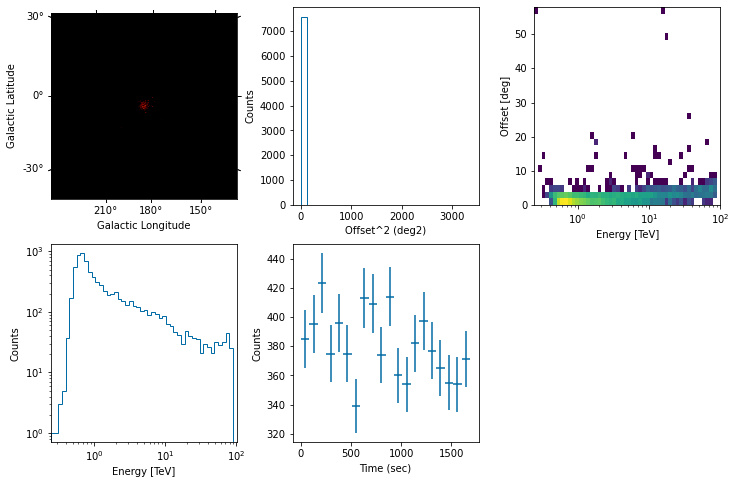

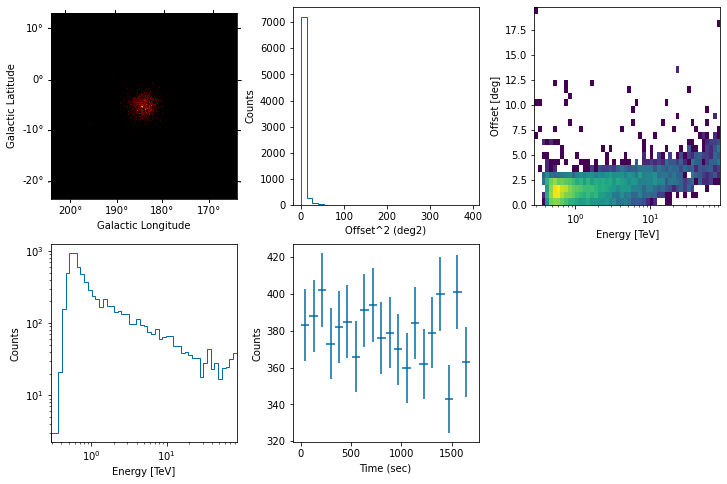

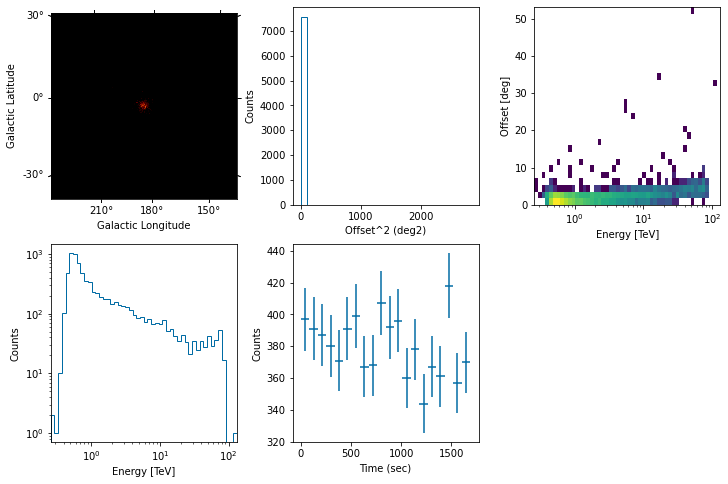

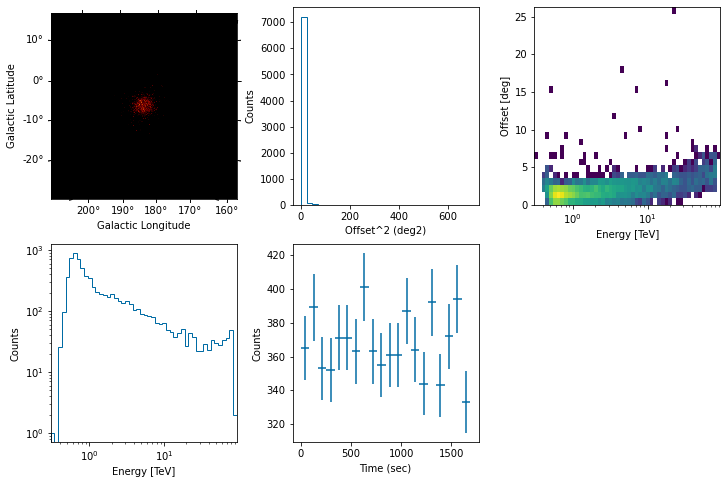

In [16]:
for i in range(len(obs_collection)):
    obs_collection[i].events.peek()

In [17]:
if start_time == 'auto':
    start_time = obs_collection[0].tstart
    for i in range(len(obs_collection)):
        if start_time > obs_collection[i].tstart:
            start_time = obs_collection[i].tstart
if stop_time == 'auto':
    stop_time = obs_collection[0].tstop
    for i in range(len(obs_collection)):
        if stop_time < obs_collection[i].tstop:
            stop_time = obs_collection[i].tstop

In [18]:
n_bin_time = int((stop_time-start_time)/time_bin)
effective_time_bin = (stop_time-start_time)/n_bin_time

In [19]:
times = start_time + np.arange(n_bin_time) * effective_time_bin
time_intervals = [
    Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])
]

In [20]:
rebinned_observations = obs_collection.select_time(time_intervals)

# Define on Region and exclusion region

In [21]:
on_region = CircleSkyRegion(center=source_position, radius=on_radius)
exclude_region = CircleSkyRegion(center=source_position, radius=exclusion_radius)

In [22]:
n_bin_energy_reco = int((np.log10(e_max_reco.to_value(u.TeV))-np.log10(e_min_reco.to_value(u.TeV)))*n_bin_per_decade_e_reco)
energy_axis_reco = MapAxis.from_edges(
    np.logspace(np.log10(e_min_reco.to_value(u.TeV)), np.log10(e_max_reco.to_value(u.TeV)), n_bin_energy_reco), unit="TeV", name="energy", interp="log"
)
n_bin_energy_true = int((np.log10(e_max_true.to_value(u.TeV))-np.log10(e_min_true.to_value(u.TeV)))*n_bin_per_decade_e_true)
energy_axis_true = MapAxis.from_edges(
    np.logspace(np.log10(e_min_true.to_value(u.TeV)), np.log10(e_max_true.to_value(u.TeV)), n_bin_energy_true), unit="TeV", name="energy_true", interp="log"
)

In [23]:
geom_on_region = RegionGeom.create(region=on_region, axes=[energy_axis_reco])
geom = WcsGeom.create(
    skydir=source_position, npix=(200, 200), binsz=0.02, frame="icrs", axes=[energy_axis_reco], 
)
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (200, 200, 25)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

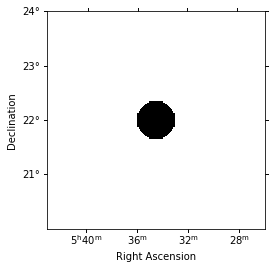

In [24]:
geom_image = geom.to_image()
exclusion_mask = ~geom_image.region_mask([exclude_region])
exclusion_mask.sum_over_axes().plot();

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


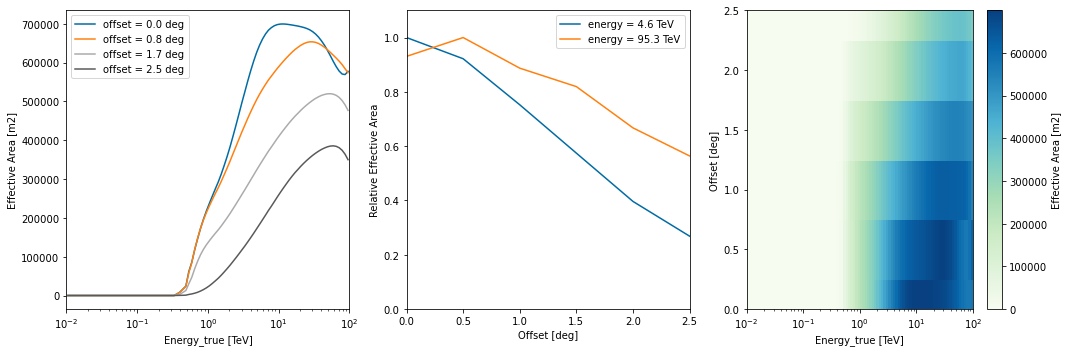

In [25]:
if obs_collection[0].aeff is not None:
    obs_collection[0].aeff.peek()

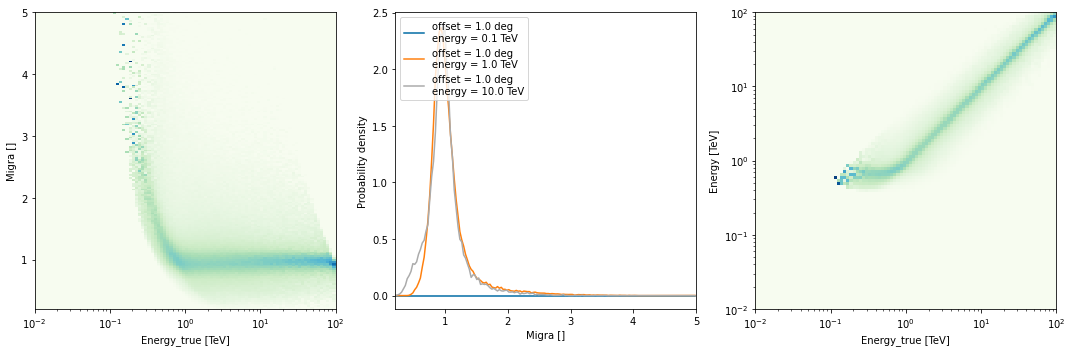

In [26]:
if obs_collection[0].edisp is not None:
    obs_collection[0].edisp.peek()

In [27]:
if obs_collection[0].bkg is not None:
    obs_collection[0].bkg.peek()

# Ligh curve computation

In [28]:
dataset_maker_spectrum = SpectrumDatasetMaker(selection=["counts", "exposure", "edisp"], use_region_center=True)
spectrum_dataset_empty = SpectrumDataset.create(geom=geom_on_region, energy_axis_true=energy_axis_true)
bkg_maker_spectrum = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

dataset_stacked_map = MapDataset.create(geom=geom, name=source_name+'_stacked')
map_dataset_maker = MapDatasetMaker(selection=["counts"])
map_maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max="4 deg")

datasets_spectrum_joint = Datasets()
for obs in rebinned_observations:
    dataset_spectrum = dataset_maker_spectrum.run(spectrum_dataset_empty.copy(name=f"obs-{obs.obs_id}+{obs.tstart}_{obs.tstop}"), obs)
    dataset_on_off_spectrum = bkg_maker_spectrum.run(observation=obs, dataset=dataset_spectrum)
    datasets_spectrum_joint.append(dataset_on_off_spectrum)
    
    map_cutout = dataset_stacked_map.cutout(obs.pointing_radec, width="6.5 deg")
    map_dataset = map_dataset_maker.run(map_cutout, obs)
    map_dataset = map_maker_safe_mask.run(map_dataset, obs)
    dataset_stacked_map.stack(map_dataset)
    
info_table = datasets_spectrum_joint.info_table(cumulative=True)

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


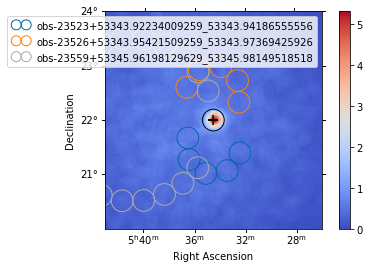

In [29]:
#plt.figure(figsize=(8, 8))
ax = dataset_stacked_map.to_image().counts.smooth('0.12 deg', kernel='disk').plot(add_cbar=True, cmap='coolwarm')
on_region.to_pixel(ax.wcs).plot(ax=ax, color='black')
plot_spectrum_datasets_off_regions(datasets=datasets_spectrum_joint, ax=ax)
plt.gca().scatter(source_position.ra, source_position.dec, transform=plt.gca().get_transform('world'), marker='+', c='k', label=source_name, s=[100])
plt.show()

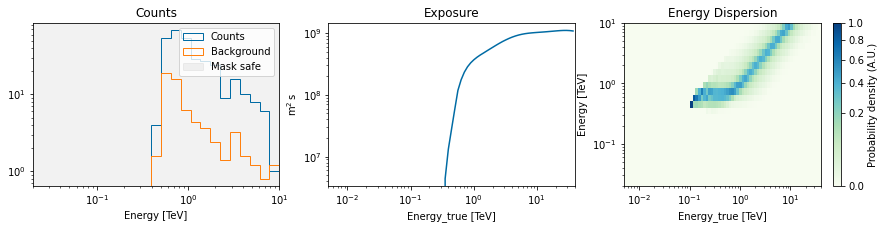

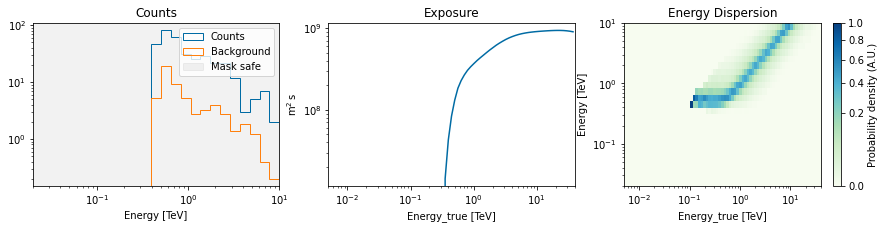

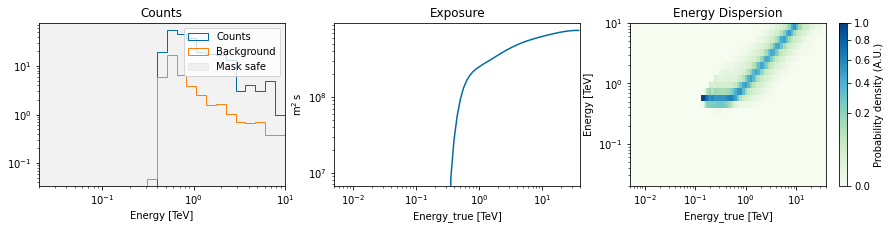

In [30]:
for dataset in datasets_spectrum_joint:
    plt.figure(figsize=(15, 3))
    dataset.peek()

In [31]:
model
datasets_spectrum_joint.models = [model]

In [32]:
lc_maker= LightCurveEstimator(
    energy_edges=e_range_light_curve, source=source_name, reoptimize=False, n_sigma_ul=3, selection_optional='all', time_intervals=time_intervals
)
lc = lc_maker.run(datasets_spectrum_joint)

In [33]:
lc.to_table(sed_type='eflux', format='lightcurve')

time_min,time_max,e_ref [1],e_min [1],e_max [1],eflux [1],eflux_err [1],eflux_errp [1],eflux_errn [1],eflux_ul [1],ts [1],sqrt_ts [1],"npred [1,3]","npred_excess [1,3]",stat [1],is_ul [1],"counts [1,3]",success [1],"norm_scan [1,11]","stat_scan [1,11]"
,,TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,bool,float64,float64
53343.922340092584,53344.92493268518,0.4472135954999579,0.02,9.999999999999998,9.52868559122989e-10,4.724938869485005e-11,4.784975564947794e-11,4.666255955842445e-11,1.1001516780004857e-09,836.0494608580311,28.914519896723707,301.06658715133113 .. nan,237.41790771484375 .. nan,55.02931803578437,False,310.0 .. nan,True,0.2 .. 4.999999999999999,498.8127122547388 .. 2397.3510866510096
53345.92752527777,53346.93011787037,0.4472135954999579,0.02,9.999999999999998,9.722756576888168e-10,7.626146709068741e-11,7.792651638753938e-11,7.46197517628282e-11,1.2162251072570002e-09,434.0866030482009,20.834745091989987,nan .. 239.48660622442065,nan .. 196.84347534179688,13.155923558665581,False,nan .. 240.0,True,0.2 .. 4.999999999999999,215.22277653061633 .. 879.9251123945568


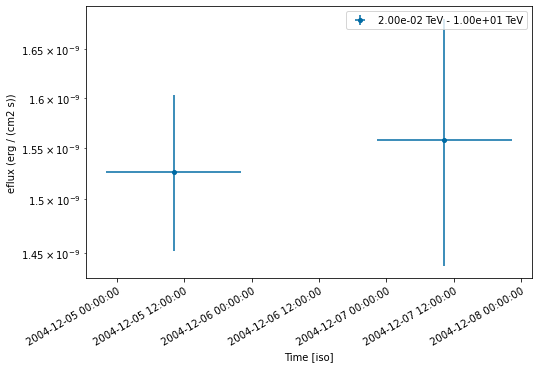

In [34]:
plt.figure(figsize=(8, 5))
ax = lc.plot(sed_type='eflux')
plt.savefig(os.path.join(path_plot,'{}__run_wise_ligh_curve.png'.format(filename_output)), dpi=300)